In [1]:
! pip install numpy pandas plotly openpyxl matplotlib scikit-learn statsmodels


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [206]:
import glob
from PIL import Image
import random
import matplotlib.image as img
import numpy as np
import os
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import tarfile
import zipfile
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from urllib.request import urlretrieve
from os.path import isfile, isdir
import plotly.express as px
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%matplotlib inline

# Punto 1

### Cargar datos

In [5]:
def download_files():
    """
    Este metodo descarga los archivos de imagenes sino existen
    """
    path_tar = os.path.join("data",'faces.zip')
    if not isfile(path_tar):
        urlretrieve(
            'http://courses.media.mit.edu/2002fall/mas622j/proj/faces/rawdata.zip',
            path_tar)
    dest_path =  "data/faces"
    with zipfile.ZipFile(path_tar) as tar:
        tar.extractall(dest_path)
        tar.close()
download_files()

In [207]:
d_name = 'data/faces/rawdata'
sample = 0.2
x = []
for nfile in  os.listdir(d_name):
    if random.random() <= sample:
        bytes_read = open(os.path.join(d_name,nfile), "rb").read()
        img = Image.frombytes('L', (128,128), bytes_read)
        x.append(np.array(img).flatten())

x = np.array(x)

In [208]:
def plot_n_images(data,n=1):
    fn_shape = lambda x: x.reshape(128,128)
    fig, ax = plt.subplots(1,n, constrained_layout=True)
    if n == 1:
        ax.imshow(fn_shape(data))
        ax.set_title(label="Image %s"% str(n))
    else:
        for i in range(n):
            ax[i].imshow(fn_shape(data[i+1]))
            ax[i].set_title(label="Image %s"% str(i+1))
    plt.show()

### 1.Mean face


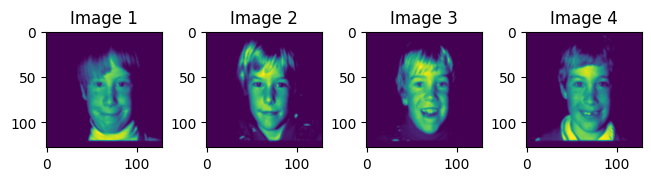

In [209]:
plot_n_images(x,4)

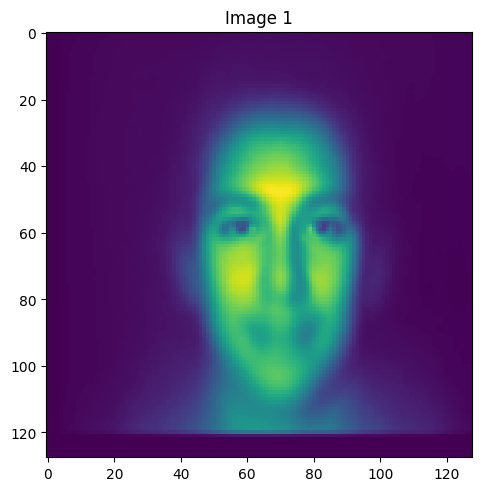

In [210]:
x_mean = x.mean(axis=0)
plot_n_images(x_mean, 1)

### 2. PCA

##### Centrar

In [211]:
x_center = x - x_mean

##### Eigen faces y eigen values

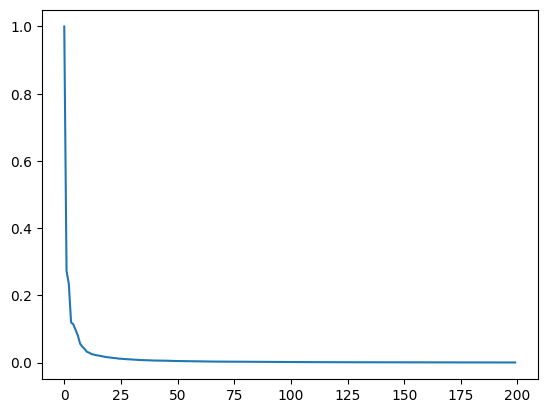

In [212]:
pca = PCA(n_components=200)
X_reduced = pca.fit_transform(x_center)
eigen_values = pca.explained_variance_
eigen_faces = pca.components_
plt.plot(range(0,200), eigen_values/eigen_values[0])

###### Según la gráfica, con 1 o 2 componentes se pueden mantener el 90% de las caracteríasticas


In [213]:
def find_variance_percentage(percentage, values):
    current_percentage=0
    total_variance = np.sum(values)
    for i in range(len(values)):
        current_percentage = current_percentage + values[i]/total_variance
        if current_percentage>=percentage:
            return i

find_variance_percentage(0.9, eigen_values)


44

##### Se necesitan 45 componentes para mantener el 90% de las caracteríasticas

##### Mean face + 1 comp

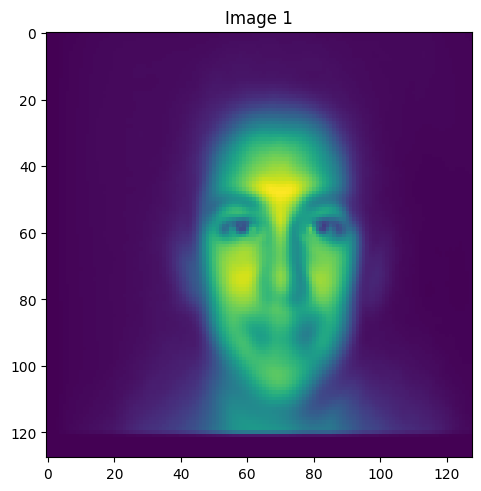

In [214]:
plot_n_images(x_mean + eigen_faces[0], 1)

##### Mean face + 5 comp

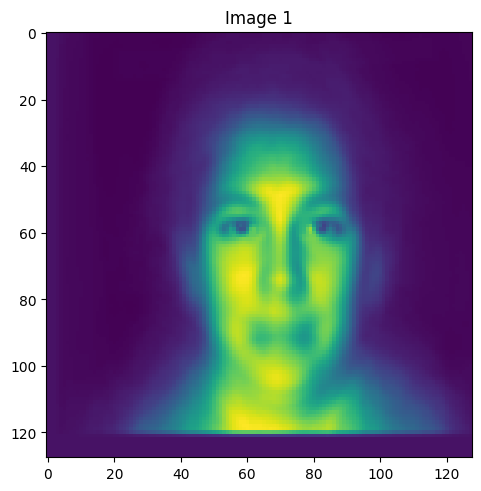

In [215]:
face_5 = x_mean + np.sum(np.dot(X_reduced[1].reshape(1,-1)[:,:5],
                                 eigen_faces[:5,:]),
                            axis=0)
plot_n_images(face_5, 1)

##### Mean face + 10 comp

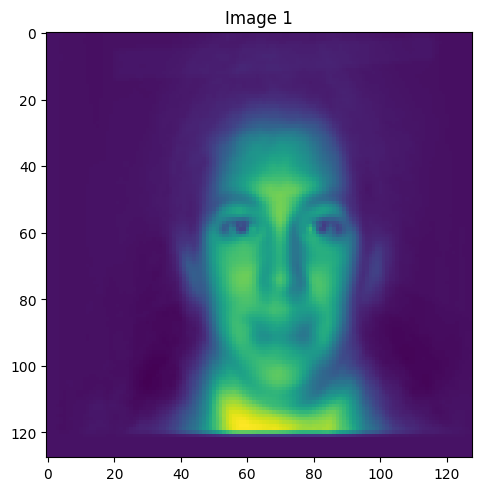

In [216]:
face_10 = x_mean + np.sum(np.dot(X_reduced[1].reshape(1,-1)[:,:10],
                                 eigen_faces[:10,:]),
                            axis=0)
plot_n_images(face_10, 1)

##### Mean face + 90% varianza

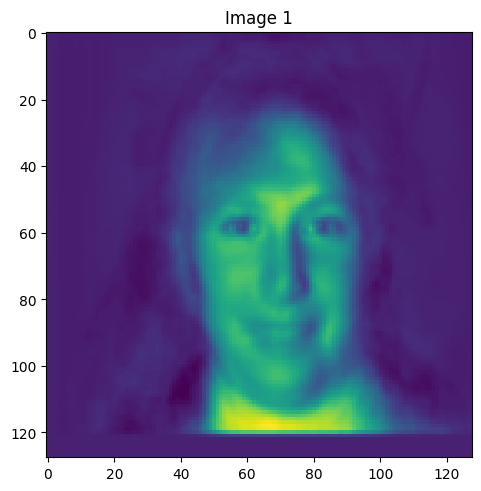

In [217]:
face_90v = x_mean + np.sum(np.dot(X_reduced[1].reshape(1,-1)[:,:45],
                                 eigen_faces[:45,:]),
                            axis=0)
plot_n_images(face_90v, 1)

##### Mean face + 99 % varianza

In [218]:
find_variance_percentage(0.99, eigen_values)

160

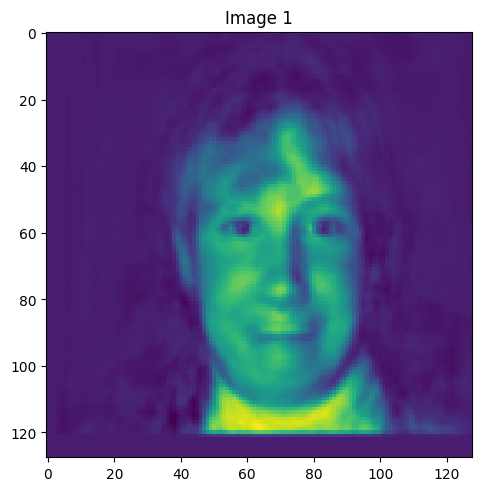

In [219]:
face_99v = x_mean + np.sum(np.dot(X_reduced[1].reshape(1,-1)[:,:159],
                                 eigen_faces[:159,:]),
                            axis=0)
plot_n_images(face_99v, 1)

# Punto 2

In [285]:
k = 5
col_names = ["comp_"+str(i) for i in range(len(eigen_faces[0]))]

In [286]:

df = pd.DataFrame(eigen_faces, columns=col_names)
df['labels'] = pd.DataFrame([random.randint(0,k) for i in range(200)])
df_new_labels = pd.DataFrame([0 for i in range(200)])


In [287]:
def labels_are_diff(equalty):
    for i in range(len(equalty)):
        if equalty[i] == False:
            return True
    return False

In [288]:
def get_labels(values, mean):
    k=5
    dist = []
    labels = []
    for i in range(200):
        dist_k = []
        for j in range(k):
            dist_k.append(np.linalg.norm(values[i]-mean[j]))
        dist.append(dist_k)
    for n in range(200):
        labels.append(np.argmin(dist[n]))
    return labels

In [289]:
labels_are_diff(df['labels'].values == df_new_labels[0].values)

True

In [290]:
mu_k = df.groupby('labels').agg('mean')
first_iteration=True
while labels_are_diff(df['labels'].values == df_new_labels[0].values):
    if first_iteration:
       df_new_labels = pd.DataFrame(df['labels'].values)
       first_iteration = False
    df['labels'] = df_new_labels
    mu_k = df.groupby('labels').agg('mean')
    new_labels = get_labels(df[col_names].values, mu_k.values)
    df_new_labels = pd.DataFrame(new_labels)
df['labels']
        

0      3
1      3
2      2
3      2
4      0
5      3
6      3
7      2
8      3
9      1
10     2
11     3
12     4
13     4
14     0
15     3
16     3
17     2
18     3
19     1
20     3
21     2
22     3
23     0
24     3
25     3
26     3
27     3
28     4
29     3
30     3
31     1
32     1
33     0
34     1
35     0
36     4
37     1
38     2
39     3
40     3
41     3
42     3
43     3
44     0
45     3
46     4
47     1
48     2
49     1
50     3
51     2
52     3
53     1
54     2
55     3
56     0
57     3
58     4
59     3
60     4
61     3
62     3
63     4
64     4
65     3
66     3
67     4
68     4
69     0
70     0
71     0
72     1
73     2
74     4
75     4
76     0
77     3
78     3
79     2
80     3
81     0
82     1
83     3
84     4
85     3
86     0
87     1
88     0
89     1
90     4
91     3
92     3
93     2
94     2
95     2
96     0
97     3
98     3
99     3
100    3
101    1
102    2
103    3
104    4
105    2
106    3
107    4
108    2
109    3
110    2
1

In [271]:
mu_k

,comp_0,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10,comp_11,comp_12,comp_13,comp_14,comp_15,comp_16,comp_17,comp_18,comp_19,comp_20,comp_21,comp_22,comp_23,comp_24,comp_25,comp_26,comp_27,comp_28,comp_29,comp_30,comp_31,comp_32,comp_33,comp_34,comp_35,comp_36,comp_37,comp_38,comp_39,comp_40,comp_41,comp_42,comp_43,comp_44,comp_45,comp_46,comp_47,comp_48,comp_49,comp_50,comp_51,comp_52,comp_53,comp_54,comp_55,comp_56,comp_57,comp_58,comp_59,comp_60,comp_61,comp_62,comp_63,comp_64,comp_65,comp_66,comp_67,comp_68,comp_69,comp_70,comp_71,comp_72,comp_73,comp_74,comp_75,comp_76,comp_77,comp_78,comp_79,comp_80,comp_81,comp_82,comp_83,comp_84,comp_85,comp_86,comp_87,comp_88,comp_89,comp_90,comp_91,comp_92,comp_93,comp_94,comp_95,comp_96,comp_97,comp_98,comp_99,comp_100,comp_101,comp_102,comp_103,comp_104,comp_105,comp_106,comp_107,comp_108,comp_109,comp_110,comp_111,comp_112,comp_113,comp_114,comp_115,comp_116,comp_117,comp_118,comp_119,comp_120,comp_121,comp_122,comp_123,comp_124,comp_125,comp_126,comp_127,comp_128,comp_129,comp_130,comp_131,comp_132,comp_133,comp_134,comp_135,comp_136,comp_137,comp_138,comp_139,comp_140,comp_141,comp_142,comp_143,comp_144,comp_145,comp_146,comp_147,comp_148,comp_149,comp_150,comp_151,comp_152,comp_153,comp_154,comp_155,comp_156,comp_157,comp_158,comp_159,comp_160,comp_161,comp_162,comp_163,comp_164,comp_165,comp_166,comp_167,comp_168,comp_169,comp_170,comp_171,comp_172,comp_173,comp_174,comp_175,comp_176,comp_177,comp_178,comp_179,comp_180,comp_181,comp_182,comp_183,comp_184,comp_185,comp_186,comp_187,comp_188,comp_189,comp_190,comp_191,comp_192,comp_193,comp_194,comp_195,comp_196,comp_197,comp_198,comp_199,comp_200,comp_201,comp_202,comp_203,comp_204,comp_205,comp_206,comp_207,comp_208,comp_209,comp_210,comp_211,comp_212,comp_213,comp_214,comp_215,comp_216,comp_217,comp_218,comp_219,comp_220,comp_221,comp_222,comp_223,comp_224,comp_225,comp_226,comp_227,comp_228,comp_229,comp_230,comp_231,comp_232,comp_233,comp_234,comp_235,comp_236,comp_237,comp_238,comp_239,comp_240,comp_241,comp_242,comp_243,comp_244,comp_245,comp_246,comp_247,comp_248,comp_249,...,comp_16134,comp_16135,comp_16136,comp_16137,comp_16138,comp_16139,comp_16140,comp_16141,comp_16142,comp_16143,comp_16144,comp_16145,comp_16146,comp_16147,comp_16148,comp_16149,comp_16150,comp_16151,comp_16152,comp_16153,comp_16154,comp_16155,comp_16156,comp_16157,comp_16158,comp_16159,comp_16160,comp_16161,comp_16162,comp_16163,comp_16164,comp_16165,comp_16166,comp_16167,comp_16168,comp_16169,comp_16170,comp_16171,comp_16172,comp_16173,comp_16174,comp_16175,comp_16176,comp_16177,comp_16178,comp_16179,comp_16180,comp_16181,comp_16182,comp_16183,comp_16184,comp_16185,comp_16186,comp_16187,comp_16188,comp_16189,comp_16190,comp_16191,comp_16192,comp_16193,comp_16194,comp_16195,comp_16196,comp_16197,comp_16198,comp_16199,comp_16200,comp_16201,comp_16202,comp_16203,comp_16204,comp_16205,comp_16206,comp_16207,comp_16208,comp_16209,comp_16210,comp_16211,comp_16212,comp_16213,comp_16214,comp_16215,comp_16216,comp_16217,comp_16218,comp_16219,comp_16220,comp_16221,comp_16222,comp_16223,comp_16224,comp_16225,comp_16226,comp_16227,comp_16228,comp_16229,comp_16230,comp_16231,comp_16232,comp_16233,comp_16234,comp_16235,comp_16236,comp_16237,comp_16238,comp_16239,comp_16240,comp_16241,comp_16242,comp_16243,comp_16244,comp_16245,comp_16246,comp_16247,comp_16248,comp_16249,comp_16250,comp_16251,comp_16252,comp_16253,comp_16254,comp_16255,comp_16256,comp_16257,comp_16258,comp_16259,comp_16260,comp_16261,comp_16262,comp_16263,comp_16264,comp_16265,comp_16266,comp_16267,comp_16268,comp_16269,comp_16270,comp_16271,comp_16272,comp_16273,comp_16274,comp_16275,comp_16276,comp_16277,comp_16278,comp_16279,comp_16280,comp_16281,comp_16282,comp_16283,comp_16284,comp_16285,comp_16286,comp_16287,comp_16288,comp_16289,comp_16290,comp_16291,comp_16292,comp_16293,comp_16294,comp_16295,comp_16296,comp_16297,comp_16298,comp_16299,comp_16300,comp_16301,comp_16

# Punto 3

In [ ]:
df = pd.read_excel("./Data/saber2020-1.xlsx")

In [ ]:

def split_df(df):
    return train_test_split(df, test_size= 0.2)

### Descartamos columnas innecesarias

In [ ]:
def convert_date_to_age(df):
    time = pd.Timestamp('now')
    df['ESTU_EDAD']=(time - pd.to_datetime(df['ESTU_FECHANACIMIENTO'], errors="coerce")).astype('<m8[Y]')
    return df.drop('ESTU_FECHANACIMIENTO', axis=1)

In [ ]:
def delete_unnecesary_columns(df):
    unnecessary_columns = [x for x in df if df[x].count() <30 or x[0:3]=='MOD' or len(df[x].unique()) < 2 or "COD" in x]
    unnecessary_columns.extend(['ESTU_CONSECUTIVO', 'PERCENTIL_GLOBAL', 'PERCENTIL_NBC'])
    df = df.drop(columns=unnecessary_columns, axis=1)
    categorical = df.drop(columns=df._get_numeric_data().columns, axis= 1)
    df = df.drop(columns=categorical)
    non_significant_categorical = [x for x in categorical if categorical[x].count()-list(categorical[x].value_counts())[0] < 30]
    categorical = categorical.drop(columns=non_significant_categorical, axis=1)
    return pd.concat([df, categorical], axis=1)


In [ ]:
def return_value_by_index(index, categories):
    for cat in categories:
        if cat[0] == index:
            return cat[1]

In [ ]:
def categorize(df, col):
    indexes = df[[col,'PUNT_GLOBAL']].groupby(col).agg(['count', 'mean']).index
    avg = df[[col,'PUNT_GLOBAL']].groupby(col).agg(['count', 'mean']).values[:,1]
    categories = pd.qcut(avg, 5, labels=['Baja', 'Media_baja', 'Media', 'Media_alta', 'Alta'])
    categorized = list(zip(indexes, categories))
    df[col+'_CATEGORIZED'] = df[col].apply(lambda x: return_value_by_index(x, categorized))
    return df

In [ ]:
def apply_transformations(df):
    columns_less_30 = ['ESTU_MCPIO_RESIDE', 'ESTU_COLE_TERMINO', 'ESTU_OTROCOLE_TERMINO', 'INST_NOMBRE_INSTITUCION', 'ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_MUNICIPIO']
    for col in columns_less_30:
        col_transfromed = set([i for i,v in zip(df['ESTU_MCPIO_RESIDE'].value_counts().index, df['ESTU_MCPIO_RESIDE'].value_counts().values) if v > 30])
        df[col] = df[col].apply(lambda x: x if x in col_transfromed else 'OTRO')
    df["ESTU_SEMESTRECURSA"] = df["ESTU_SEMESTRECURSA"].apply(lambda x: 12.0 if x == "12 o mÃ¡s" else float(x))
    df["ESTU_DEPTO_PRESENTACION"] = df["ESTU_DEPTO_PRESENTACION"].apply(lambda x: x if x == "BOGOTÃ" else 'OTRO')
    df["ESTU_MCPIO_PRESENTACION"] = df["ESTU_MCPIO_PRESENTACION"].apply(lambda x: x if x == "BOGOTÃ D.C." else 'OTRO')
    df["FAMI_CUANTOSCOMPARTEBAÃ‘O"] = df["FAMI_CUANTOSCOMPARTEBAÃ‘O"].apply(lambda x: '0 a 2' if x == 1 or x == 2 or x=="NINGUNA" else x)
    df["ESTU_TIPODOCUMENTO"] = df['ESTU_TIPODOCUMENTO'].apply(lambda x: "OTRO" if x=="PE" or x=="PEP" else x)
    non_significant_mean_difference = ['ESTU_NIVEL_PRGM_ACADEMICO', 'ESTU_GENERO', 'ESTU_ESTADOINVESTIGACION',
                                    'ESTU_TITULOOBTENIDOBACHILLER','ESTU_PAGOMATRICULABECA', 'ESTU_PAGOMATRICULAPADRES']
    df = df.drop(columns= non_significant_mean_difference, axis=1)
    df = categorize(df, 'ESTU_MCPIO_RESIDE')
    df = categorize(df, 'ESTU_PRGM_MUNICIPIO')
    df = categorize(df, 'ESTU_INST_MUNICIPIO')
    return df
    

In [ ]:
def fill_nans_with_mean(df):
    numerical = df._get_numeric_data().columns
    for x in df:
        if x in numerical:
            mean = df[x].mean()
            df[x] = df[x].fillna(mean)
    return df


In [ ]:
def create_dummies(df):
    df = fill_nans_with_mean(df)
    numerical = df._get_numeric_data().columns
    dummies = [x for x in df if not x in numerical]
    df_dummies = pd.get_dummies(df[dummies],prefix=dummies,dummy_na=True,drop_first=False)
    df = df.drop(columns=dummies, axis=1)
    return pd.concat((df_dummies,df),axis = 1)

In [ ]:
df_train, df_test = split_df(df)

In [ ]:
df_train = convert_date_to_age(df_train)
df_test = convert_date_to_age(df_test)

In [ ]:
df_train = delete_unnecesary_columns(df_train)
df_test = delete_unnecesary_columns(df_test)

In [ ]:
df_train = apply_transformations(df_train)
df_test = apply_transformations(df_test)

In [ ]:
df_train.describe(include='all')

,ESTU_SNIES_PRGMACADEMICO,PUNT_GLOBAL,ESTU_EDAD,ESTU_TIPODOCUMENTO,ESTU_NACIONALIDAD,ESTU_PAIS_RESIDE,ESTU_DEPTO_RESIDE,ESTU_MCPIO_RESIDE,ESTU_AREARESIDE,ESTU_ESTADOCIVIL,ESTU_COLE_TERMINO,ESTU_OTROCOLE_TERMINO,ESTU_PAGOMATRICULACREDITO,ESTU_PAGOMATRICULAPROPIO,ESTU_COMOCAPACITOEXAMENSB11,ESTU_TIPODOCUMENTOSB11,ESTU_SEMESTRECURSA,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,FAMI_TRABAJOLABORPADRE,FAMI_TRABAJOLABORMADRE,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_TIENESERVICIOTV,FAMI_TIENECOMPUTADOR,FAMI_TIENELAVADORA,FAMI_TIENEHORNOMICROOGAS,FAMI_TIENEAUTOMOVIL,FAMI_TIENEMOTOCICLETA,FAMI_TIENECONSOLAVIDEOJUEGOS,FAMI_CUANTOSCOMPARTEBAÃ‘O,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,INST_NOMBRE_INSTITUCION,ESTU_PRGM_ACADEMICO,GRUPOREFERENCIA,ESTU_PRGM_MUNICIPIO,ESTU_PRGM_DEPARTAMENTO,ESTU_METODO_PRGM,ESTU_NUCLEO_PREGRADO,ESTU_INST_MUNICIPIO,ESTU_INST_DEPARTAMENTO,INST_CARACTER_ACADEMICO,INST_ORIGEN,ESTU_MCPIO_PRESENTACION,ESTU_DEPTO_PRESENTACION,ESTU_MCPIO_RESIDE_CATEGORIZED,ESTU_PRGM_MUNICIPIO_CATEGORIZED,ESTU_INST_MUNICIPIO_CATEGORIZED
count,54931.000000,54980.000000,54926.000000,54980,54980,54980,54950,54980,46753,46502,54980,54980,46719,46719,46731,46197,46722.000000,52189,52096,45403,48376,51666,51590,51467,51254,51214,51086,51063,51082,51034,51093,50964,50887,54980,54980,54980,54980,54980,54980,54980,54980,54980,54980,54980,54980,54980,54980,54980,54980
unique,NaN,NaN,NaN,5,15,15,34,146,2,4,2,2,2,2,3,5,NaN,12,12,13,13,7,2,2,2,2,2,2,2,2,4,7,5,1,1,20,102,32,3,50,51,25,5,6,2,2,5,5,5
top,NaN,NaN,NaN,CC,COLOMBIA,COLOMBIA,BOGOTÃ,BOGOTÃ D.C.,Cabecera Municipal,Soltero,OTRO,OTRO,No,No,RepasÃ³ por cuenta propia,TI,NaN,Primaria incompleta,Secundaria (Bachillerato) completa,Trabaja por cuenta propia (por ejemplo plomero...,"Trabaja en el hogar, no trabaja o estudia",Estrato 2,Si,Si,Si,Si,No,No,No,No,3 o 4,No pago semestre,MÃ¡s de 30 horas,OTRO,OTRO,TECNOLÃ“GICO EN ADMINISTRACIÃ“N Y TURISMO,BOGOTÃ D.C.,BOGOTÃ,PRESENCIAL,ADMINISTRACIÃ“N,BOGOTÃ D.C.,BOGOTÃ,INSTITUCIÃ“N TECNOLÃ“GICA,OFICIAL NACIONAL,BOGOTÃ D.C.,BOGOTÃ,Alta,Alta,Media_baja
freq,NaN,NaN,NaN,53766,54934,54934,15811,15811,39197,36473,54977,54979,41980,32756,33617,28628,NaN,13407,12959,7843,23500,23802,45153,37774,44714,41106,30672,42096,31765,42495,24508,32187,21263,54980,54980,23385,19901,19901,48348,18998,45638,45638,39583,41326,54356,54356,22550,28264,46125
mean,85436.355628,93.164915,28.316262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.642353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,26936.214350,20.128673,7.425828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.823672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,174.000000,0.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,91157.000000,79.000000,23.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,91186.000000,94.000000,26.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,102350.000000,107.000000,32.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_test.describe(include='all')

In [ ]:
df_train = create_dummies(df_train)
df_test = create_dummies(df_train)

In [ ]:
y_train = df_train[['PUNT_GLOBAL']]
x = df_train.drop('PUNT_GLOBAL', axis=1)
x_train = sm.add_constant(x)
model = sm.OLS(y_train,x_train).fit()
model.summary()

In [ ]:
y_test = df_test[['PUNT_GLOBAL']]
x = df_test.drop('PUNT_GLOBAL', axis=1)
x_test = sm.add_constant(x)
model = sm.OLS(y_test,x_test).fit()
model.summary()

In [ ]:
y_hat_train = model.predict(x_train)
y_hat = model.predict(x_test)
mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test, y_hat)
print(f"Erro calculado en train, test: {mse_train},{mse_test}")